In [1]:
import pandas as pd
import pybedtools
from functools import reduce
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
import upsetplot

In [3]:
import sys
sys.path.append("../")
import utils as ut

In [4]:
peak_dir = "/data5/deepro/starrseq/main_library/3_peak_call/data"
lib_names = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

In [5]:
def bedtools_add(a,b):
    return a+b

def bedtools_subtract(a,b):
    return a-b

def get_intersect_counts(include_beds, exclude_beds):
    intersect_bed = reduce(bedtools_add, include_beds)
    if len(exclude_beds)>0:
        exclude_beds = [intersect_bed] + exclude_beds
        intersect_bed = reduce(bedtools_subtract, exclude_beds)
    return intersect_bed.count()

def get_upset_df(lib_names):
    peak_files = [ut.get_peak_file(peak_dir, ln) for ln in lib_names]
    peak_bed_dict = {ln: pybedtools.BedTool(pf) for ln,pf in zip(lib_names, peak_files)}
    peak_boolean_dict = {ln:[] for ln in lib_names}
    counts = []
    for i in range(1, len(lib_names) + 1):
        all_combos = list(combinations(lib_names, i))
        for combos in all_combos:
            include_combos = combos
            exclude_combos = [ln for ln in lib_names if ln not in include_combos]
            include_beds = [peak_bed_dict[c] for c in include_combos]
            exclude_beds = [peak_bed_dict[c] for c in exclude_combos]
            counts.append(get_intersect_counts(include_beds, exclude_beds))
            for c in include_combos:
                peak_boolean_dict[c].append(True)
            for c in exclude_combos:
                peak_boolean_dict[c].append(False)
    peak_boolean_dict["counts"] = counts
    df = pd.DataFrame(peak_boolean_dict)
    return df.set_index(lib_names)



In [6]:
upset_df = get_upset_df(lib_names)

In [30]:
parsed_upset_df = upset_df.loc[[[True if i==j else False for i in range(8)] for j in range(8)] + [[True for i in range(8)]], :]

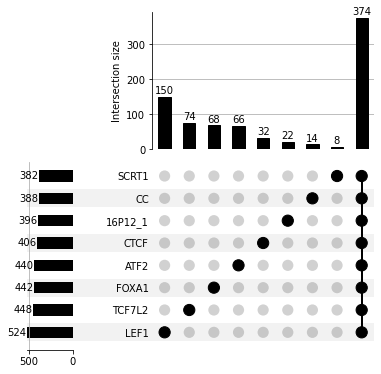

In [32]:
fig = upsetplot.plot(parsed_upset_df.counts, show_counts=True);

In [8]:
upset_df

counts
CC    ATF2  CTCF  FOXA1 LEF1         
True  False False False False      44
False True  False False False      68
      False True  False False      84
            False True  False     143
                  False True      202
True  True  False False False       2
      False True  False False      27
            False True  False      34
                  False True       55
False True  True  False False       2
            False True  False       6
                  False True       28
      False True  True  False      56
                  False True       13
            False True  True      165
True  True  True  False False       1
            False True  False       2
                  False True       13
      False True  True  False     261
                  False True       53
            False True  True      148
False True  True  True  False       0
                  False True        5
            False True  True       33
      False True  True  True       11
True  True  True  True  False      60
                  False True       22
            False True  True       41
      False True  True  True      289
False True  True  True  True        4
True  True  True  True  True      384

In [9]:
pybedtools.helpers.cleanup(remove_all=True)